## Классификация
Задача: вычислить мошенника на страховых выплатах

Для выполнения лабораторной работы были выбраны метрики F1-score и ROC-AUC, так как исследуемый датасет является несбалансированным. Метрика Accuracy в данном случае неинформативна, так как модель, предсказывающая всем класс ‘0’ (не фрод), может иметь высокую Accuracy, но будет бесполезна. F1-score позволит контролировать баланс между ложными срабатываниями и пропуском мошенников.

### Baseline

Скачаем датасет с kaggle

In [89]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


Замапим колонки с Yes или No значениями в 1 и 0, пропуски заполним -1. Это нужно, потому что модели не умеют работать со строковыми данными.

In [90]:
df_clean = df.copy()

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)
df_clean["property_damage"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)

Закодируем каждое не числовое значение просто номером.

In [91]:
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,940,2,1,1000,1406.91,0,466132,...,1.0,71610,6510,13020,52080,10,1,2004,1,NaN
1,228,42,342868,635,1,1,2000,1197.22,5000000,468176,...,-1.0,5070,780,780,3510,8,12,2007,1,NaN
2,134,29,687698,413,2,0,2000,1413.14,5000000,430632,...,0.0,34650,7700,3850,23100,4,30,2007,0,NaN
3,256,41,227811,19,0,1,2000,1415.74,6000000,608117,...,0.0,63400,6340,6340,50720,3,34,2014,1,NaN
4,228,44,367455,922,0,2,1000,1583.91,6000000,610706,...,0.0,6500,1300,650,4550,0,31,2009,0,NaN


Заполним пропуски нулями. Модели не умеют работать с NaNами.

In [92]:
df_clean = df_clean.fillna(0)

Разделим на данные и таргет, предварительно удалив даты из датасета. Модели не умеют работать с датами. Далее разобьем на тестовую и обучающую выборку.

In [93]:
from sklearn.model_selection import train_test_split
drop_dates = ["policy_bind_date", "incident_date"]
df_clean = df_clean.drop(drop_dates, axis=1)
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Обучим KNN с параметрами по умолчанию и выведем метрики.

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

model = KNeighborsClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.0594
ROC-AUC: 0.4674
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       226
           1       0.11      0.04      0.06        74

    accuracy                           0.68       300
   macro avg       0.43      0.47      0.43       300
weighted avg       0.58      0.68      0.62       300



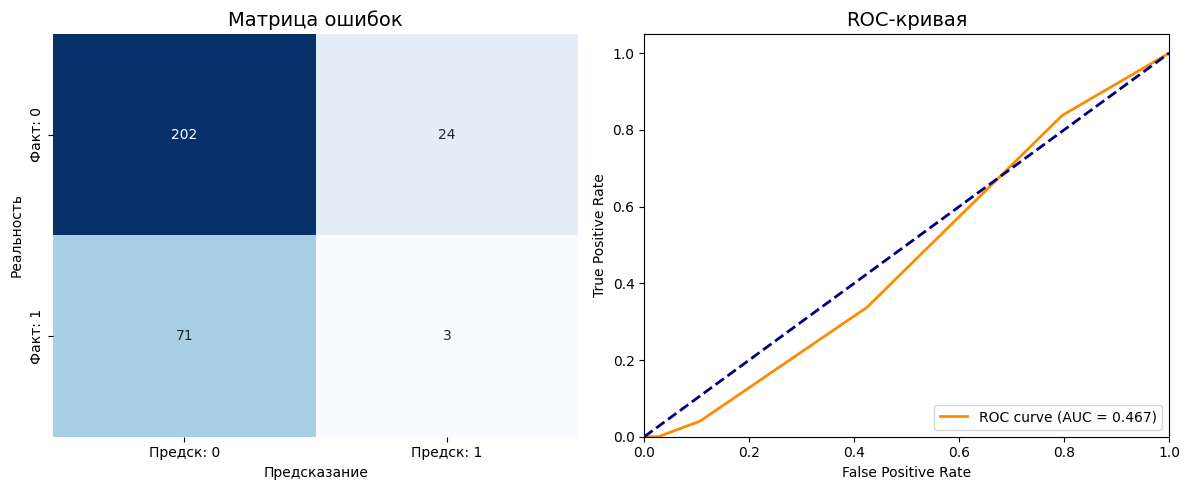

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
def graphics(y_test, y_pred, y_prob):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Предск: 0', 'Предск: 1'],
                yticklabels=['Факт: 0', 'Факт: 1'])
    plt.title("Матрица ошибок", fontsize=14)
    plt.ylabel("Реальность")
    plt.xlabel("Предсказание")

    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
graphics(y_test, y_pred, y_prob)


Модель очень плохо определяет мошенников. Accuracy, которая выводится в логах неинформативна, поскольку из-за дисбаланса классов многих просто записывает в честных, тем самым повышая accuracy. На это указывает и F1 метрика, которая для 1 класса очень высокая, а для второго крайне низкая. ROC-AUC менее 0.5, следовательно модель работает хуже случайного угадывания для ранжирования вероятностей класса 1. То есть предсказания вероятностей фактически не информативны.

### Improved KNN

Загрузим датасет и сразу выведем пропуски по столбцам.

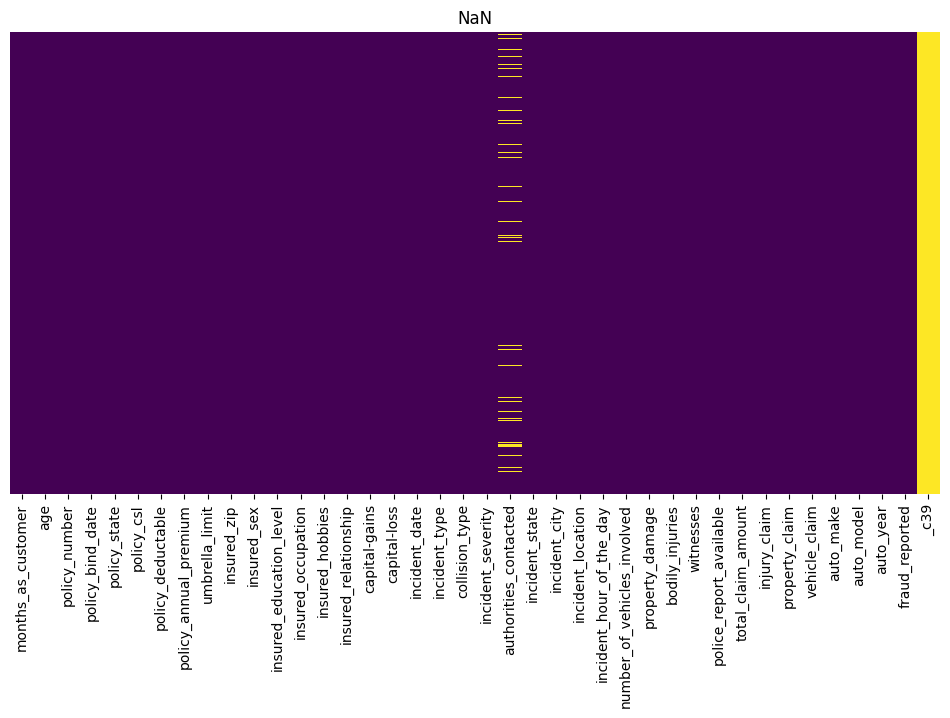

In [96]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df_i = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")

nulls = df_i.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df_i)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df_i.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

Видим, что столбец '_c39' полностью пустой, как следствие неинформативен, его можно сразу же удалить. Кроме того, в столбце с контактами таже присутствуют пропуски. Заполним их меткой 'Нет контактов'.

In [97]:
df_clean_i = df_i.copy()
df_clean_i = df_clean_i.drop(columns=["_c39"])
df_clean_i["authorities_contacted"] = df_clean_i["authorities_contacted"].fillna("No Contact")

Удостоверимся, что присутствует дисбаланс классов.

In [98]:
TARGET_NAME = "fraud_reported"
df_clean_i[TARGET_NAME].value_counts()

fraud_reported
N    753
Y    247
Name: count, dtype: int64

Посмотрим на столбцы с бинарными метками 'police_report_available' и 'property_damage'

In [99]:
display(df_clean_i["police_report_available"].unique())
display(df_clean_i["property_damage"].unique())

array(['YES', '?', 'NO'], dtype=object)

array(['YES', '?', 'NO'], dtype=object)

Закодируем YES - 1, NO - 0 и пропуски -1. В целевой переменной так же поменяем значения на бинарные.

In [100]:
import pandas as pd

df_clean_i["fraud_reported"] = df_clean_i["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean_i["police_report_available"] = df_clean_i["police_report_available"].map({'YES': 1, 'NO': 0, '?': -1})
df_clean_i["property_damage"] = df_clean_i["property_damage"].map({'YES': 1, 'NO': 0, '?': -1})

Переформатируем строковые столбцы с датой в то, что понимает pandas.

In [101]:
dates_cols = ["policy_bind_date", "incident_date"]
for c in dates_cols:
    df_clean_i[c] = pd.to_datetime(df_clean_i[c])
df_clean_i

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,1,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,-1,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,0,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,-1,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,-1,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,1,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,1,46980,5220,5220,36540,Audi,A5,1998,0


Проверим корелляции переменных друг с другом.

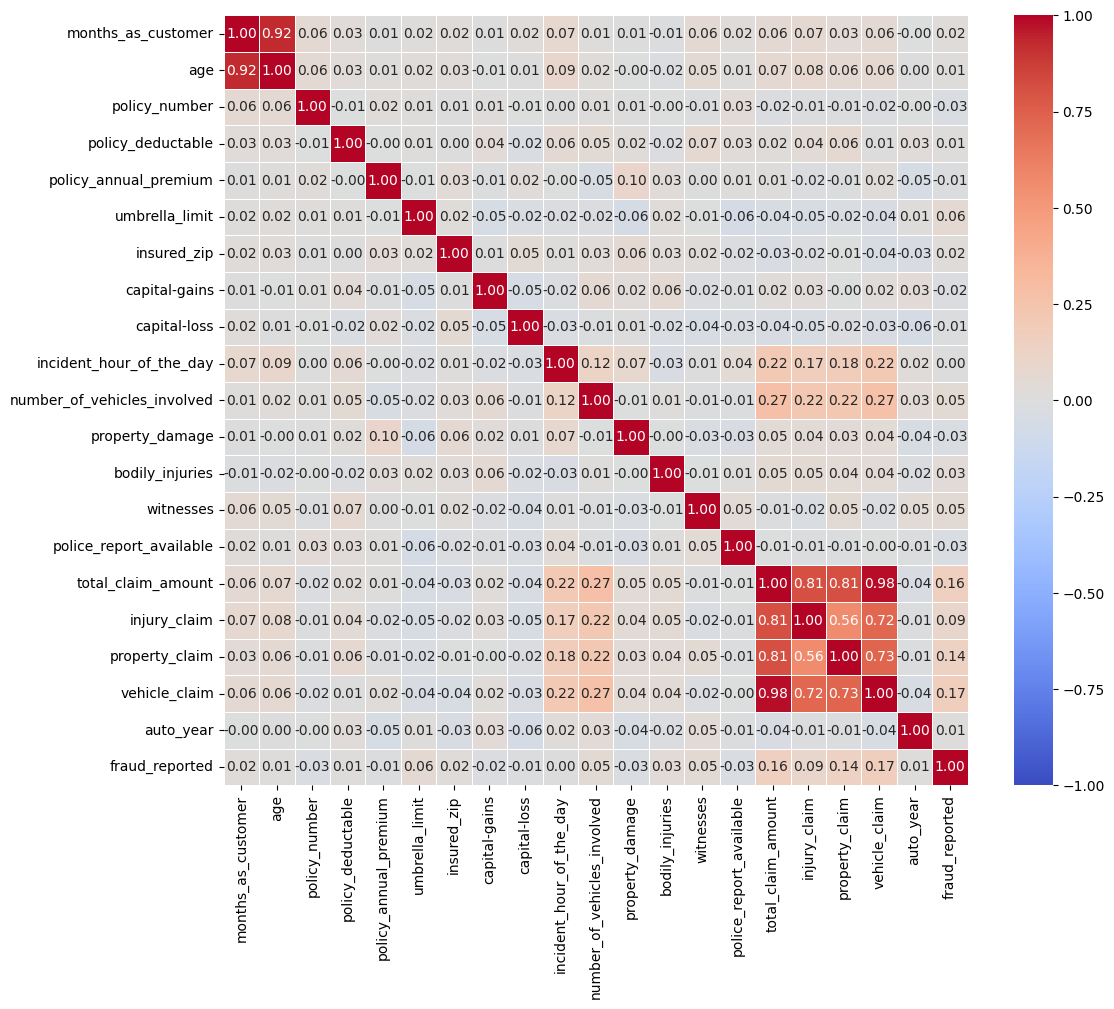

In [102]:
num_cols = df_clean_i.select_dtypes(include=["int64", "float64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_clean_i[num_cols].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.show()

Видим много кореллирующих столбцов. Может в будующем попробуем почистить данные от корелляций.

Проверим числовые столбцы на то, нет ли каких-то странностей в них.

In [103]:
num_cols = df_clean_i.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_clean_i[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,5.462386e+05,2.570630e+05,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
insured_zip,1000.0,5.012145e+05,7.170161e+04,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00


umbrella_limit -100000 min выглядит так, будто бы им заполняли отсутствие записей. Исправим это медианой.

In [104]:
import numpy as np

df_pr_i = df_clean_i.copy()

median_value = df_pr_i.loc[df_pr_i['umbrella_limit'] != -100000, 'umbrella_limit'].median()
df_pr_i.loc[df_pr_i['umbrella_limit'] == -100000, 'umbrella_limit'] = median_value

Займемся feature инжинирингом. Сначала распихаем возраст по бакетам, потом разберём дату инцидента на месяц, год и день недели. Добавим некоторые фичи коэфициенты для стоимости средства передвижения, травм и имущества относительно размера выплаты. В конце уберем уже ненужные данные по датам.

In [105]:
df_features_i = df_pr_i.copy()

df_features_i["age_bucket"] = pd.cut(
    df_features_i["age"],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=["<25", "25-34", "35-44", "45-54", "55-64", "65+"],
)

df_features_i["incident_year"] = df_features_i["incident_date"].dt.year
df_features_i["incident_month"] = df_features_i["incident_date"].dt.month
df_features_i["incident_dow"] = df_features_i["incident_date"].dt.dayofweek

df_features_i["injury_ratio"] = df_features_i["injury_claim"] / (df_features_i["total_claim_amount"] + 1e-3)
df_features_i["property_ratio"] = df_features_i["property_claim"]  / (df_features_i["total_claim_amount"] + 1e-3)
df_features_i["vehicle_ratio"] = df_features_i["vehicle_claim"] / (df_features_i["total_claim_amount"] + 1e-3)

drop_dates = ["policy_bind_date", "incident_date"]
df_features_i = df_features_i.drop(drop_dates, axis=1)

In [106]:
from sklearn.model_selection import train_test_split
X_i = df_features_i.drop(TARGET_NAME, axis=1)
y_i = df_features_i[TARGET_NAME]
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.3, random_state=42, stratify=y_i)

Тут пайплайн немного поменялся, я добавил нормализацию данных, поскольку KNN это жизненно необходимо, закодируем категориальные столбцы, применим SMOTE, чтобы выровнять дисбаланс классов, и при помощи GridSearch подберем гиперпараметры для числа соседей.

Кстати без SMOTE модель предсказывает только 1 класс (честных), а использование StandartScaler вместо Robust ухудшаешь ROC-AUC на 0.3

Очень сильно влияет на модель выбор энкодера для категориальных признаков. Использование Onehot нежелательно, поскольку сильно размывает расстояние между векторами, TargetEncoder также ломает модель, потому что не передаёт статистические различия между категориями. Я выбор остановил на WOEEncoder. Он идеален для датасетов с дисбалансом классов для бинарной классификации, поскольку учитывает вероятность приближения фичёй записи к той или иной категории.

In [107]:
from category_encoders import WOEEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

num_cols = X_i.select_dtypes(["int64", "float64"]).columns.tolist()
cat_cols = X_i.select_dtypes(["object", "category"]).columns.tolist()

numeric_pipe     = Pipeline([("scale", RobustScaler())])

categorical_pipe = Pipeline([("woe", WOEEncoder())])

ct  = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

model_pipe = ImbPipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

knn_params = {
    "model__n_neighbors": [3, 5, 7, 15, 31]
}

grid = GridSearchCV(model_pipe, knn_params, cv=3, scoring='roc_auc', verbose=1)
grid.fit(X_train_i, y_train_i)

print(f"Лучшее k: {grid.best_params_['model__n_neighbors']}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшее k: 15
F1-score (класс 1): 0.6667
ROC-AUC: 0.8545
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       226
           1       0.58      0.78      0.67        74

    accuracy                           0.81       300
   macro avg       0.75      0.80      0.77       300
weighted avg       0.84      0.81      0.82       300



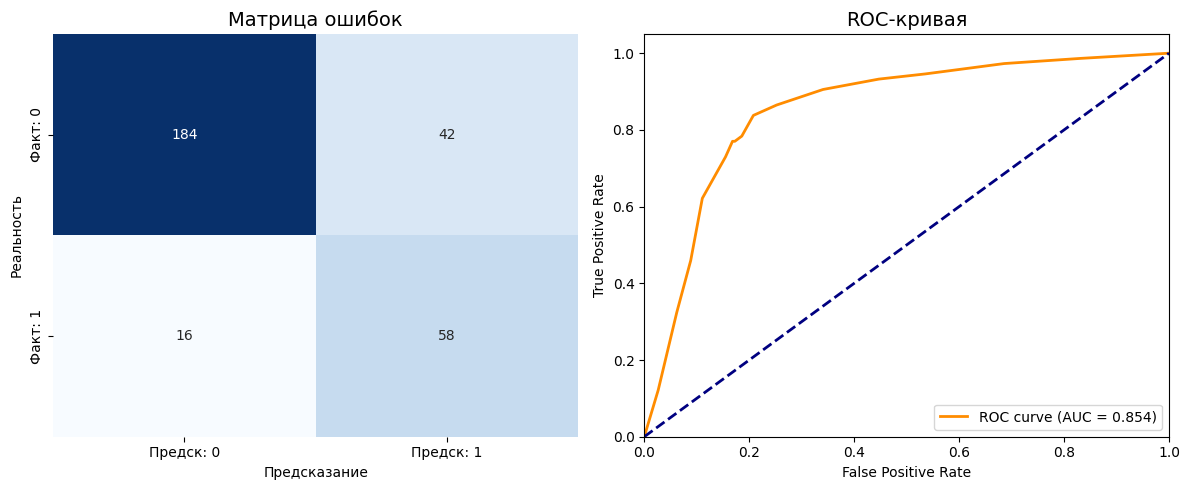

In [108]:
graphics(y_test_i, y_pred, y_prob)

Модель угадывает большую часть мошенников, при этом почти не обвиняя честных людей в махинациях. ROC_AUC и F1 метрика сильно приросли посравнению с базовым пайплайном.

### My implemenation

In [65]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter
from scipy.spatial.distance import cdist

class MyKNN(ClassifierMixin, BaseEstimator):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(self.y_train)
        return self

    def _compute_distances(self, X):
        X = np.array(X)
        return cdist(X, self.X_train, metric='euclidean')

    def predict(self, X):
        distances_matrix = self._compute_distances(X)
        predictions = []

        for distances in distances_matrix:
            k = min(self.n_neighbors, len(self.X_train))
            k_idx = np.argsort(distances)[:k]
            k_labels = self.y_train[k_idx]

            most_common = Counter(k_labels).most_common(1)[0][0]
            predictions.append(most_common)

        return np.array(predictions)

    def predict_proba(self, X):
        distances_matrix = self._compute_distances(X)
        probabilities = []

        for distances in distances_matrix:
            k = min(self.n_neighbors, len(self.X_train))
            k_idx = np.argsort(distances)[:k]
            k_labels = self.y_train[k_idx]
            prob_one = np.mean(k_labels == 1)
            probabilities.append([1 - prob_one, prob_one])

        return np.array(probabilities)

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

model = MyKNN()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.0594
ROC-AUC: 0.4674
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       226
           1       0.11      0.04      0.06        74

    accuracy                           0.68       300
   macro avg       0.43      0.47      0.43       300
weighted avg       0.58      0.68      0.62       300



In [67]:
model_pipe = ImbPipeline([
    ('ct', ct),
    ('smote', SMOTE(random_state=42)),
    ('model', MyKNN())
])

grid = GridSearchCV(model_pipe, knn_params, cv=3, scoring='roc_auc', verbose=1)
grid.fit(X_train_i, y_train_i)

print(f"Лучшее k: {grid.best_params_['model__n_neighbors']}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшее k: 15
F1-score (класс 1): 0.6667
ROC-AUC: 0.8546
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       226
           1       0.58      0.78      0.67        74

    accuracy                           0.81       300
   macro avg       0.75      0.80      0.77       300
weighted avg       0.84      0.81      0.82       300



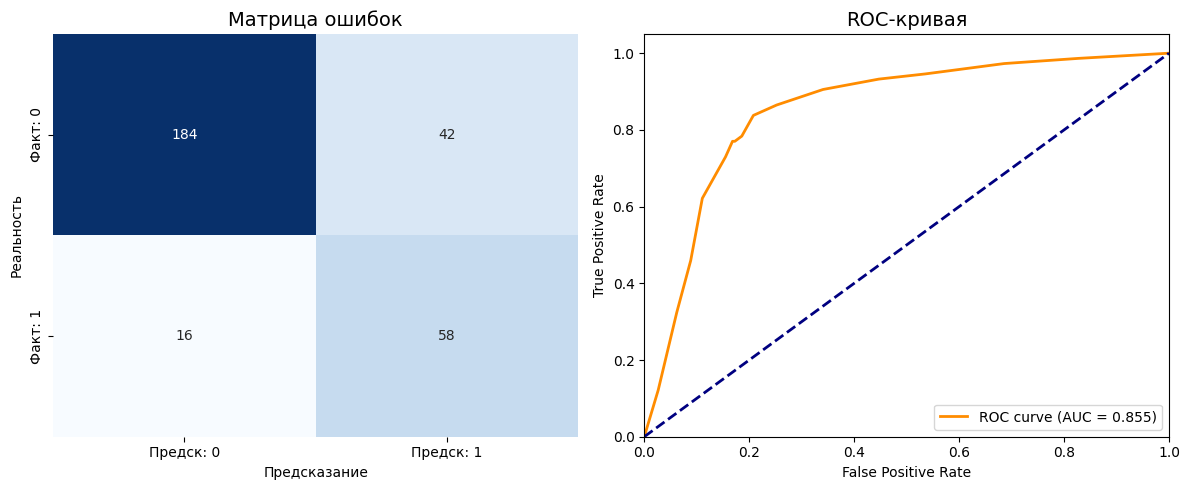

In [68]:
graphics(y_test, y_pred, y_prob)

Моя имплементация работает так же как и из scikit-learn. Там никаких хитростей нет, поэтому нормально работает.

|         | Base KNN | Improved KNN | My improved KNN |
|---------|----------|--------------| ----------------|
| ROC_AUC | 0.4674   | 0.8545       |  0.8545         |
| F1 (1)  | 0.81     | 0.86         |0.86             |
| F1 (2)  | 0.06     | 0.67         | 0.67            |

## Регрессия
Задача: предсказать зарплату игрока НХЛ по его статистике.

Будем использовать MAE, так как она очень наглядная, будет легко понять, насколько долларов ошибается модель. В качестве дополнительной метрики будем использовать R^2, чтобы смотреть насколько отличается предсказание от среднего.

### Baseline

In [69]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")

df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

Сделаем минимальные телодвижения, чтобы регрессор заработал: закодируем все строковые данные, уберем NaN

In [70]:
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [71]:
TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [72]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
knn = KNeighborsRegressor(n_neighbors=25, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline KNN ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Baseline KNN ---
MAE (Ошибка в долларах): 1173197.566
R2 Score: 0.399


MAE получилось около миллиона. В целом неплохо, учитывая что данные используются только за один сезон, поэтому прямо кардинальных улучшений мы вряд-ли увидим. Ошибка всегда будет довольно-таки большая.

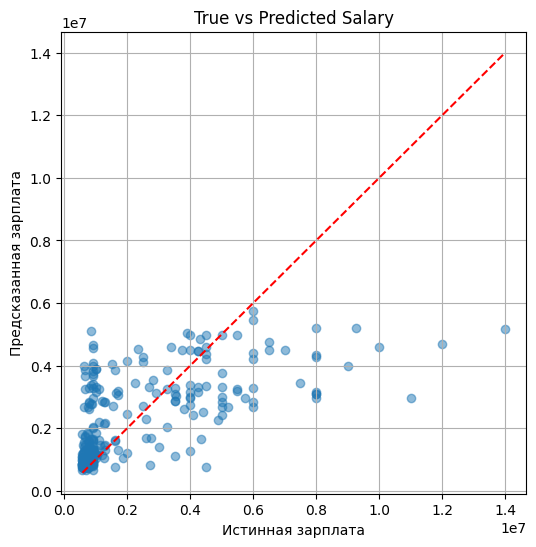

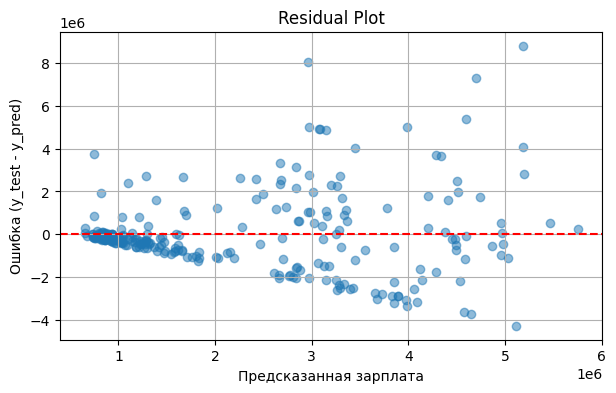

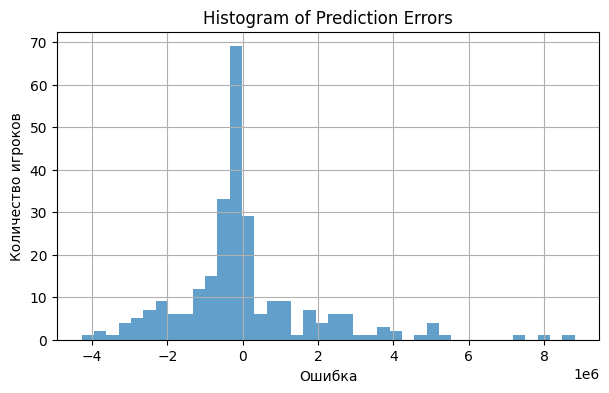

In [73]:
def true_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Истинная зарплата")
    plt.ylabel("Предсказанная зарплата")
    plt.title("True vs Predicted Salary")
    plt.grid(True)
    plt.show()

def resudial(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Предсказанная зарплата")
    plt.ylabel("Ошибка (y_test - y_pred)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()
def histogramm_error(y_test, y_pred):
    plt.figure(figsize=(7,4))
    residuals = y_test - y_pred
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title("Histogram of Prediction Errors")
    plt.xlabel("Ошибка")
    plt.ylabel("Количество игроков")
    plt.grid(True)
    plt.show()
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

По этим графикам хорошо видно, что модель нормально справляется с игроками, с низкой зарплатой, проблемы возникают с игроками, чья зарплата выбивается из общей массы (у топовых хоккеистов). При это выбросы по предсказанной зарплате тоже вполне объясними, потому что это может быть, например, молодой игрок на контракте новичка (первом контракте), у которого хорошая статистика, на уровне топового хоккеиста, но при этом небольшая зарплата, или наоборот, поскольку в НХЛ заключают долгосрочные контракты, иногда могут быть дорогостоящие хоккеисты, которые состарились или деградировали, но имеют завышенную зарплату

### Improved KNN

Загрузим датасет, посмотрим, где есть пропуски.

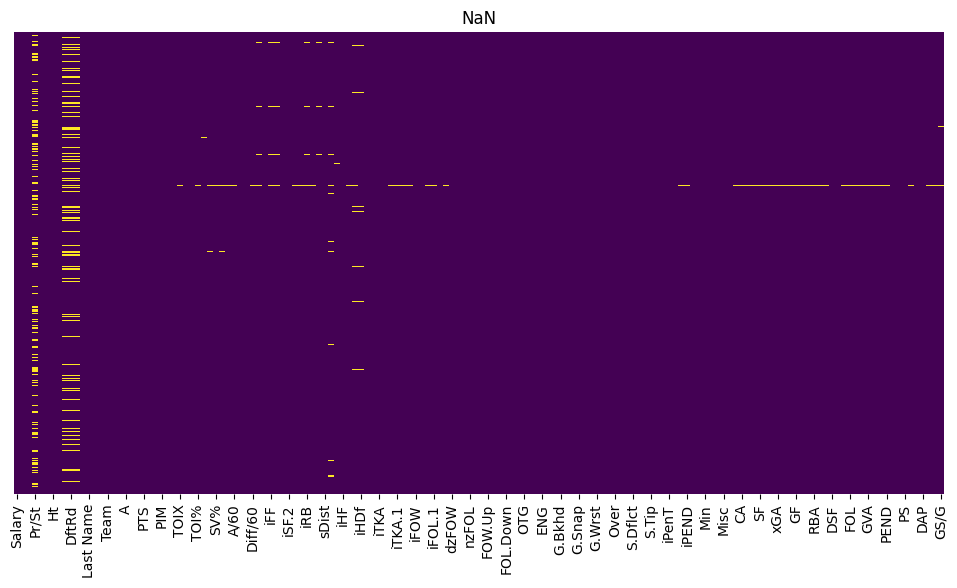

In [74]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from matplotlib import pyplot as plt


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1_i = pd.read_csv(path + "/train.csv")
df2_i = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2_i['Salary'] = salary['Salary'].values
df2_i = df2_i[df1_i.columns]
df = pd.concat([df1_i, df2_i], ignore_index=True)

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

Много игроков, которые не были задрафтованы, поэтому в этом столбце много пропусков. Pr/St тоже содержит достаточно пропусков, поскольку это только для Канады и США. В остальных столбцах пропуски постольку поскольку, заполнять их будем медианой.

In [75]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,874.0,2.325289e+06,2.298253e+06,575000.00,742500.00,925000.00,3700000.00,14000000.00
Ht,874.0,7.308238e+01,2.105485e+00,66.00,72.00,73.00,75.00,81.00
Wt,874.0,2.008432e+02,1.506008e+01,157.00,190.00,200.00,210.00,265.00
DftYr,749.0,2.008708e+03,4.380158e+00,1990.00,2006.00,2010.00,2012.00,2016.00
DftRd,749.0,2.742323e+00,1.988358e+00,1.00,1.00,2.00,4.00,9.00
...,...,...,...,...,...,...,...,...
Grit,874.0,1.267815e+02,1.016121e+02,0.00,41.00,114.00,190.00,622.00
DAP,874.0,9.215675e+00,7.815029e+00,0.00,4.60,7.60,12.00,61.00
Pace,873.0,1.089439e+02,8.899877e+00,75.00,104.70,109.20,113.90,175.70
GS,873.0,2.187331e+01,2.198638e+01,-4.30,2.60,15.70,35.40,104.70


Посмотрим теперь на топ кореллирующих столбцов.

In [76]:
import pandas as pd
import numpy as np

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = df[num_cols].corr()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

corr_pairs = corr_pairs[corr_pairs['feature_1'] < corr_pairs['feature_2']]

corr_pairs = corr_pairs.reindex(
    corr_pairs['correlation'].abs().sort_values(ascending=False).index
)

top40 = corr_pairs.head(40)

display(top40)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)


,feature_1,feature_2,correlation
4931,iSF.1,iSF.2,0.999996
8267,iFOL,iFOL.1,0.999981
8122,iFOW,iFOW.1,0.999979
6381,iHF,iHF.1,0.999957
2321,TOI,TOIX,0.999952
7398,iBLK,iBLK.1,0.999948
4787,iSF,iSF.2,0.999937
4786,iSF,iSF.1,0.999931
7108,iGVA,iGVA.1,0.999907
7253,iTKA,iTKA.1,0.999843


Их довольно-таки много. При том некоторые как-будто повторяются. Почистим данные от корреляций с некоторым барьером.

In [77]:
BARIER = 0.9998

to_drop = [col for col in upper_corr.columns if any(upper_corr[col] > BARIER)]
df_clean_i = df.drop(columns=to_drop)
df_clean_i.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


Займемся фича инжинирингом. Выделим возраст хоккеиста на начало сезона по тому, когда он родился. Добавим возраст в бакеты, также добавим в бакеты количество набранных очков. Добавим опыт, то есть сколько времени прошло с драфта. Дропнем бесполезные фичи по типу имени, фамилии, национальности (ее дублирует страна рождения), штата.

In [78]:
df_features_i = df_clean_i.copy()

df_features_i['Born'] = pd.to_datetime(df_features_i['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01')
df_features_i['Age'] = (reference_date - df_features_i['Born']).dt.days / 365.25
df_features_i['Experience'] = reference_date.year - df_features_i['DftYr']

df_features_i["Age_bucket"] = pd.cut(
    df_features_i["Age"],
    bins=[0, 20, 25, 30, 35, 40, 45],
    labels=["<20", "20-34", "25-29", "30-34", "35-39", "40+"],
)
df_features_i["PTS_bucket"] = pd.cut(
    df_features_i["PTS"],
    bins=[-1, 20, 40, 60, 80, 100, 120, 140, 160],
    labels=["<20", "20-39", "40-59", "60-79", "80-99", "100-119", "120-139", "140-159"],
)

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St']
df_features_i = df_features_i.drop(features_to_drop, axis=1)
df_features_i['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [79]:
has_nan = df_features_i.isnull().any()

columns_with_nan = has_nan[has_nan].index.tolist()

print("Столбцы, содержащие хотя бы один NaN:")
columns_with_nan

Столбцы, содержащие хотя бы один NaN:


['DftYr',
 'DftRd',
 'Ovrl',
 'TOI%',
 'IPP%',
 'SH%',
 'SV%',
 'PDO',
 'F/60',
 'A/60',
 'Diff/60',
 'iCF',
 'iFF',
 'iSF',
 'ixG',
 'iSCF',
 'iRB',
 'iRS',
 'iDS',
 'sDist.1',
 'Pass',
 'iHA',
 'iHDf',
 'BLK%',
 '%FOT',
 'iPENT',
 'iPEND',
 'CF',
 'CA',
 'FF',
 'FA',
 'SF',
 'SA',
 'xGF',
 'xGA',
 'SCF',
 'SCA',
 'GF',
 'GA',
 'RBF',
 'RBA',
 'RSF',
 'RSA',
 'FOW',
 'FOL',
 'HF',
 'HA',
 'GVA',
 'TKA',
 'PENT',
 'PEND',
 'OTOI',
 'Pace',
 'GS',
 'GS/G',
 'Experience']

In [80]:
from scipy.stats.mstats import winsorize

TARGET_NAME = 'Salary'

X_i = df_features_i.drop(TARGET_NAME, axis=1)
y_i = df_features_i[TARGET_NAME]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_i, y_i, test_size=0.2, random_state=42
)

Я разделил столбцы на те, что по распределению напоминают нормальное распределение и все остальные. Для каждого из них в сетке будет выбран скалер. Пустые данные я заполнил KNNImputerом (почему бы и нет). One hot'ом закодировал категориальные колонки, но сделал это так, чтобы сильно не размножались данные.

В сетке поискал различные расстояния, скалеры, соседей, а также логарифмировал целевую переменную, потому что иначе из-за выбросов всё сломается.

In [81]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

normal_candidates = ["Ht", "Wt", "+/-", "E+/-", "TOI%", "SH%", "SV%", "F/60",
                     "A/60", "Diff/60", "iHDf", "iPenDf", "NPD"]

cat_cols = X_i.select_dtypes(include=['object', 'category']).columns.tolist()

excluded_cols = cat_cols
normal_cols = [c for c in normal_candidates if c in X.columns and c not in excluded_cols]
power_cols = [c for c in X_i.columns if c not in normal_cols]

all_processed_cols = normal_cols + cat_cols
power_cols = [c for c in X_i.columns if c not in all_processed_cols]
power_cols = [c for c in power_cols if c in X_i.select_dtypes(include=np.number).columns]

cat_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        min_frequency=0.05
    ))
])

poly_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

normal_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

power_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

ct = ColumnTransformer(
    transformers=[
        ("cat_proc", cat_branch, cat_cols),
        ("normal_proc", normal_branch, normal_cols),
        ("power_proc", power_branch, power_cols),
    ], remainder='drop'
)

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import QuantileTransformer, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=KNeighborsRegressor(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model_wrapper__regressor__n_neighbors': [3, 5, 7, 13, 25, 41, 51],
    'model_wrapper__regressor__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'preprocessor__normal_proc__scaler': [
        StandardScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ],
    'preprocessor__power_proc__scaler': [
        RobustScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ]
}

grid = RandomizedSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)
print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
mae = mean_absolute_error(y_test_i, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_i, y_pred))
r2 = r2_score(y_test_i, y_pred)
base_mean_error = mean_absolute_error(y_test_i, [y_train.mean()]*len(y_test_i))

print(f"--- Improved KNN ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'preprocessor__power_proc__scaler': PowerTransformer(), 'preprocessor__normal_proc__scaler': QuantileTransformer(n_quantiles=400), 'model_wrapper__regressor__n_neighbors': 13, 'model_wrapper__regressor__metric': 'manhattan'}
--- Improved KNN ---
MAE (Ошибка в долларах): 1062416.379
R2 Score: 0.495


Ошибка упала, R2 вырос на 7 пунктов. Это хорошо.

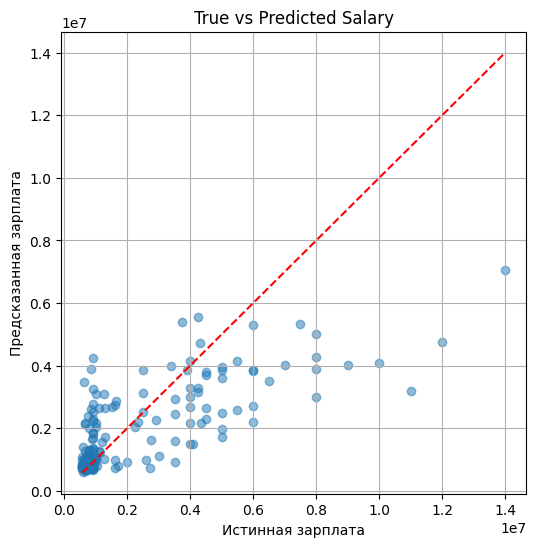

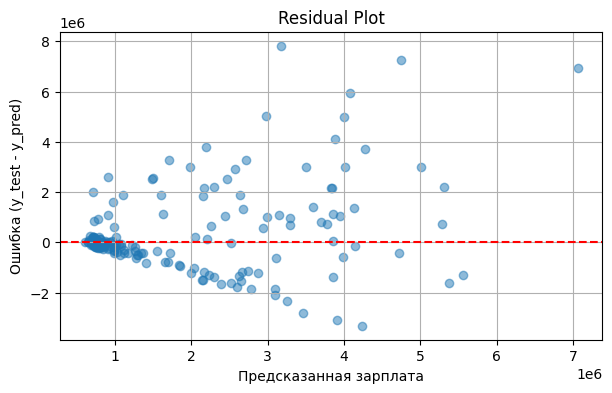

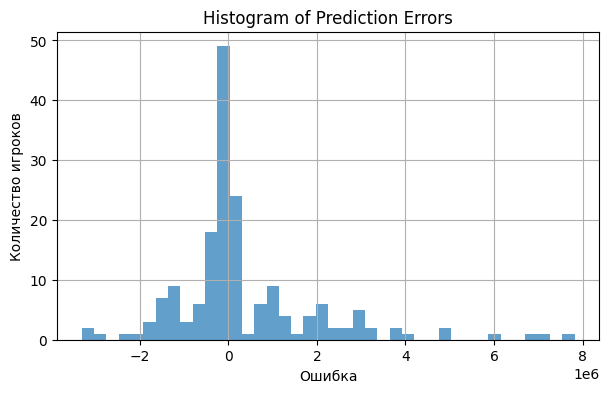

In [83]:
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Модель склонна занижать зарплату, мы видим левое смещение. Улучшенная версия стала лучше работать с игроками, чья зарплата на низком уровне.

Интересно посмотреть на то, каких игроков модель считает недооцененными и переоценнеными и совместить с реальностью.

In [84]:
original_float_format = pd.get_option('display.float_format')

pd.set_option('display.float_format', '{:.2f}'.format)

best_model = grid.best_estimator_

y_full_pred = best_model.predict(X_i)

results_df = pd.DataFrame({
    'True_Salary': y_i,
    'Predicted_Salary': y_full_pred
})

results_df['Absolute_Error'] = np.abs(results_df['True_Salary'] - results_df['Predicted_Salary'])

test_indices = X_test_i.index
final_results = pd.merge(
    df[['First Name', 'Last Name']],
    results_df,
    left_index=True,
    right_index=True
)

final_results_sorted = final_results.sort_values(by='Absolute_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---")
print(final_results_sorted.head(10).to_string())

pd.set_option('display.float_format', original_float_format)


--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---
    First Name Last Name  True_Salary  Predicted_Salary  Absolute_Error
103    Patrick      Kane  13800000.00        5329770.03      8470229.97
817     Steven   Stamkos   9500000.00        1117478.18      8382521.82
208       P.K.    Subban  11000000.00        3177578.26      7822421.74
496   Jonathan     Toews  13800000.00        6027317.60      7772682.40
542       Shea     Weber  12000000.00        4753186.47      7246813.53
626       Anze   Kopitar  14000000.00        7061935.92      6938064.08
837       Ryan  O'Reilly  11000000.00        4655718.11      6344281.89
145     Sidney    Crosby  10900000.00        4788136.07      6111863.93
861      Corey     Perry  10000000.00        4025666.48      5974333.52
260       Alex  Ovechkin  10000000.00        4075099.36      5924900.64


У Джонатана Тейвза был не самый удачный сезон: небольшой +/-, не так много очков как раньше. Ну и в целом модель хуже справляется с хоккеистами, у которых высокая зарплата. Она склонна занижать.

In [85]:
import pandas as pd
final_results['Signed_Error'] = final_results['Predicted_Salary'] - final_results['True_Salary']

overestimated_players = final_results[final_results['Signed_Error'] > 0].copy()

top_overestimated = overestimated_players.sort_values(by='Signed_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---")

print(top_overestimated[['First Name', 'Last Name',
                         'True_Salary', 'Predicted_Salary', 'Signed_Error']].head(10).to_string())


--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---
    First Name     Last Name  True_Salary  Predicted_Salary  Signed_Error
525       Leon     Draisaitl     925000.0      4.947893e+06  4.022893e+06
382       Jack        Eichel     925000.0      4.240490e+06  3.315490e+06
775     Connor       McDavid     925000.0      4.132088e+06  3.207088e+06
830    Patrick         Eaves    1000000.0      4.187564e+06  3.187564e+06
472   Jonathan  Marchessault     750000.0      3.837899e+06  3.087899e+06
393         Bo        Horvat     832500.0      3.905027e+06  3.072527e+06
477     Connor         Brown     650000.0      3.648355e+06  2.998355e+06
443     Nikita       Zaitsev     925000.0      3.892236e+06  2.967236e+06
569    Nikolaj        Ehlers     925000.0      3.782880e+06  2.857880e+06
114     Auston      Matthews     925000.0      3.768449e+06  2.843449e+06


А тут мы видим будущих звёзд НХЛ на небольших контрактах новичка: Маршессо, Эйлерс. Ветеран Эрик Стаал на небольшом контракте, но с хорошей статистикой.

### My implementation

In [86]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array

class MyKNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5, metric="euclidean", weights="uniform"):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_train_ = X
        self.y_train_ = y
        self.n_features_in_ = X.shape[1]
        return self

    def _distance(self, a, b):
        if self.metric == "euclidean":
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(a - b))
        elif self.metric == "chebyshev":
            return np.max(np.abs(a - b))
        else:
            raise ValueError(f"Unknown metric: {self.metric}")

    def _get_neighbors(self, x):
        distances = np.array([self._distance(x, x_train) for x_train in self.X_train_])
        idx = distances.argsort()[:self.n_neighbors]
        return idx, distances[idx]

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = []
        for x in X:
            idx, dists = self._get_neighbors(x)
            neighbors_y = self.y_train_[idx]
            if self.weights == "uniform":
                pred = np.mean(neighbors_y)
            elif self.weights == "distance":
                dists = np.where(dists == 0, 1e-8, dists)
                w = 1 / dists
                pred = np.sum(w * neighbors_y) / np.sum(w)
            else:
                raise ValueError("Unknown weights mode")
            predictions.append(pred)
        return np.array(predictions)

--- Baseline My KNN ---
MAE (Ошибка в долларах): 1217521.047
R2 Score: 0.357


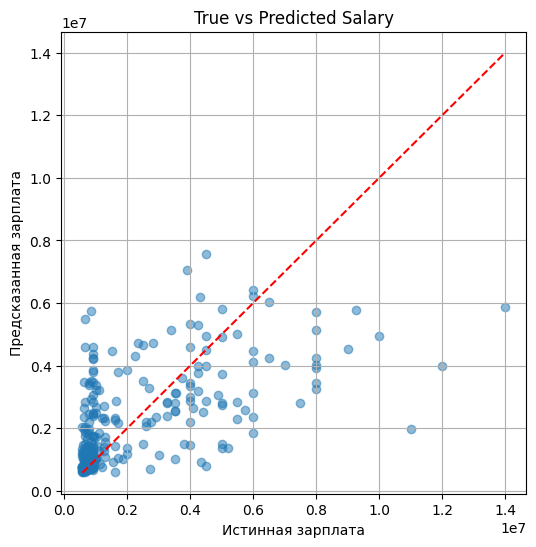

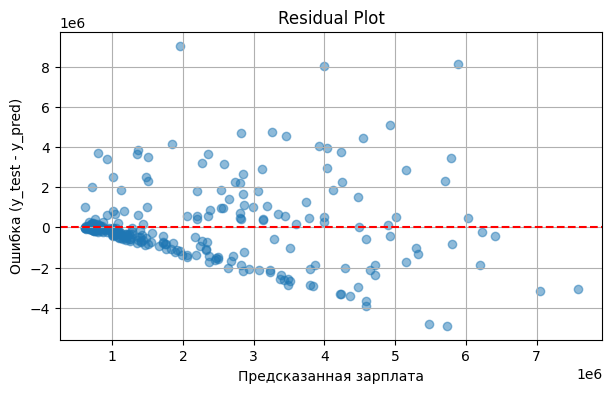

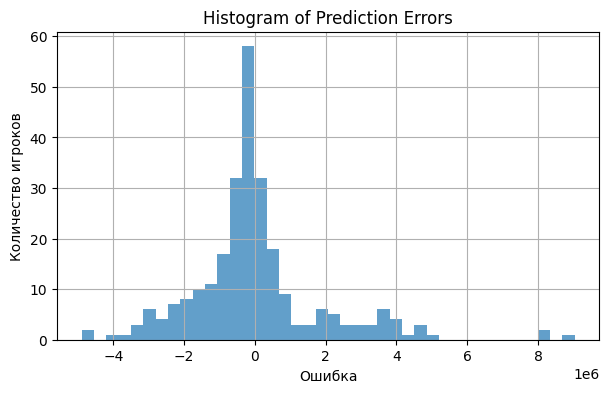

In [87]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
knn = MyKNNRegressor()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline My KNN ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'preprocessor__power_proc__scaler': QuantileTransformer(n_quantiles=400), 'preprocessor__normal_proc__scaler': QuantileTransformer(n_quantiles=400), 'model_wrapper__regressor__n_neighbors': 5, 'model_wrapper__regressor__metric': 'euclidean'}
--- MyKNN ---
MAE (Ошибка в долларах): 1105419.509
R2 Score: 0.458


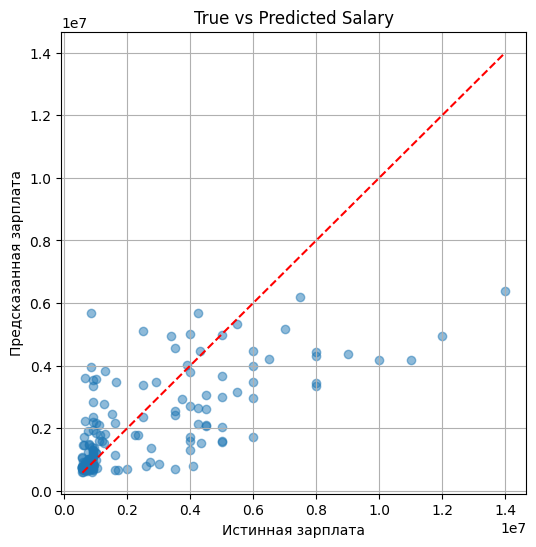

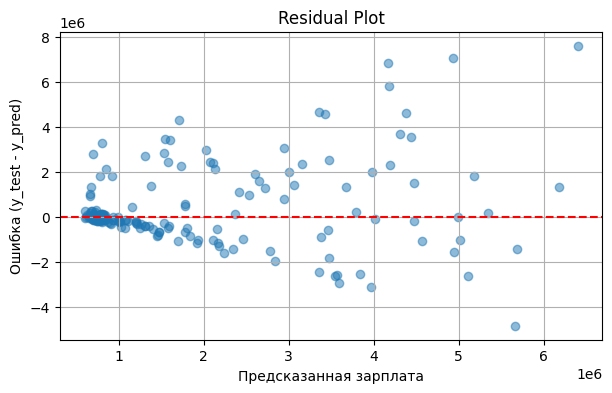

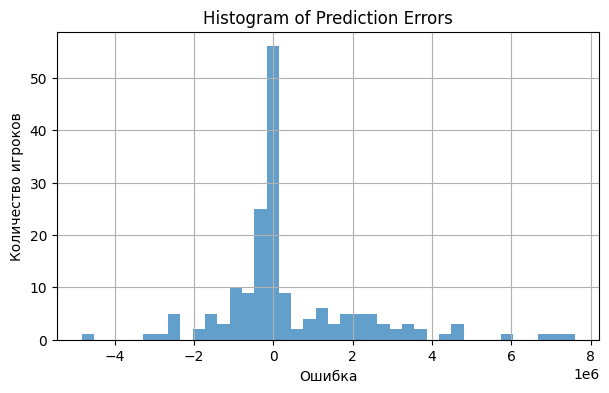

In [88]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=MyKNNRegressor(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model_wrapper__regressor__n_neighbors': [3, 5, 7, 13, 25, 41, 51],
    'model_wrapper__regressor__metric': ['euclidean', 'manhattan', 'chebyshev'],
    'preprocessor__normal_proc__scaler': [
        StandardScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ],
    'preprocessor__power_proc__scaler': [
        RobustScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ]
}

grid = RandomizedSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)
print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
mae = mean_absolute_error(y_test_i, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_i, y_pred))
r2 = r2_score(y_test_i, y_pred)
base_mean_error = mean_absolute_error(y_test_i, [y_train.mean()]*len(y_test_i))

print(f"--- MyKNN ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Собственная имплементация показывает те же самые результаты, что и встроенная в sklearn, только обучение идёт несколько медленнее из-за отсутствия оптимизаций.

|     | Base KNN    | Improved KNN | My KNN      |
|-----|-------------|--------------|-------------|
| R2  | 0.399       | 0.474        | 0.474       |
| MAE | 1173197.566 | 1027804.467  | 1027804.467 |

## Вывод

KNN очень неплохо себя показала в задаче классфикации. Даже несмотря на дисбаланс классов этому методу удалось достичь гроссмейстерских 0.85 ROC_AUC. Учитывая, насколько простой это алгоритм, это очень хороший результат.

С задачей регрессии чуть сложнее, поскольку датасет имеет очень много признаков, а также сам по себе так составлен, что ошибка большая, KNN не удалось показать хороший результат. Но так или иначе это то, от чего мы будем отталкиваться.